In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [98]:
df = pd.read_csv('/casestudy.csv')
df['date'] = pd.to_datetime(df['date'])
start_date = '2020-01-07'
end_date = '2020-02-03'
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]


df['period'] = df['date'].apply(lambda d:
    'before' if d < pd.Timestamp('2020-01-21') else
    'after' if d >= pd.Timestamp('2020-01-21') else
    'promo_day')


In [99]:
player_total_handle = df.groupby('playerid')['handle'].sum().reset_index()
handle_cutoff = player_total_handle['handle'].quantile(0.99)
valid_players = player_total_handle[player_total_handle['handle'] <= handle_cutoff]['playerid']
df= df[df['playerid'].isin(valid_players)]

In [100]:
ggr_summary = df.groupby(['Target/CG', 'period'])['ggr'].sum().unstack()
ggr_summary

period,after,before
Target/CG,,
Control Group,4510.86,5526.21
Target,17821.05,27367.76


In [101]:
agg = df.groupby(['Target/CG', 'period'])[['ggr', 'handle', 'bonus awarded']].agg(['sum', 'mean', 'median', 'count'])
agg

ggr                             handle  \
                           sum       mean median count        sum   
Target/CG     period                                                
Control Group after    4510.86  37.279835  29.84   121   91951.55   
              before   5526.21  41.550451  34.95   133  144053.27   
Target        after   17821.05  37.997974  20.88   469  619677.40   
              before  27367.76  52.935706  25.05   517  769064.63   

                                               bonus awarded             \
                             mean median count           sum       mean   
Target/CG     period                                                      
Control Group after    759.930165  176.7   121           0.0        NaN   
              before  1083.107293  253.4   133           0.0        NaN   
Target        after   1321.273774  212.0   469        6615.0  14.104478   
              before  1487.552476  258.6   517        7155.0  13.839458   

                                   
                     median count  
Target/CG     period               
Control Group after     NaN     0  
              before    NaN     0  
Target        after    10.0   469  
              before   10.0   517

In [102]:
player_counts = df.groupby(['Target/CG', 'period'])['playerid'].nunique()
player_counts

Target/CG      period
Control Group  after      32
               before     29
Target         after      97
               before    118
Name: playerid, dtype: int64

In [103]:
df.tail()

,playerid,date,handle,ggr,last_12months_segment,Target/CG,bonus awarded,period
1247,1517784,2020-02-03,11.00,-25.00,regnodep,Target,5.0,after
1248,1162357,2020-02-03,0.02,0.02,low,Target,5.0,after
1249,1332717,2020-02-03,0.00,0.00,medium,Target,10.0,after
1250,1257412,2020-02-03,0.00,0.00,low,Target,5.0,after
1251,1241465,2020-02-03,0.00,0.00,no bet,Target,5.0,after


In [104]:
summary_stats = df.groupby(['Target/CG', 'period']).agg({
    'ggr': 'sum',
    'handle': 'sum',
    'playerid': pd.Series.nunique
}).reset_index().rename(columns={'playerid': 'unique_players'})

print(summary_stats)

       Target/CG  period       ggr     handle  unique_players
0  Control Group   after   4510.86   91951.55              32
1  Control Group  before   5526.21  144053.27              29
2         Target   after  17821.05  619677.40              97
3         Target  before  27367.76  769064.63             118


In [119]:
ggr_summary = df.groupby(['Target/CG', 'period'])['ggr'].sum().unstack()
target_ggr_before = ggr_summary.loc['Target', 'before']
target_ggr_after = ggr_summary.loc['Target', 'after']
control_ggr_before = ggr_summary.loc['Control Group', 'before']
control_ggr_after = ggr_summary.loc['Control Group', 'after']

target_delta = target_ggr_after - target_ggr_before
control_delta = control_ggr_after - control_ggr_before

incremental_ggr = target_delta - control_delta

target_bonus_df = df[df['Target/CG'] == 'Target'][['playerid', 'bonus awarded']].drop_duplicates()
total_bonus = target_bonus_df['bonus awarded'].sum()

roi = incremental_ggr / total_bonus
print(" GGR Summary")
print(f"Target GGR Before: ${target_ggr_before:,.2f}")
print(f"Target GGR After:  ${target_ggr_after:,.2f}")
print(f"Control GGR Before: ${control_ggr_before:,.2f}")
print(f"Control GGR After:  ${control_ggr_after:,.2f}")
print()
print(f"Target GGR Delta:  ${target_delta:,.2f}")
print(f"Control GGR Delta: ${control_delta:,.2f}")
print(f"Incremental GGR: ${incremental_ggr:,.2f}")
print(f"Total Bonus Awarded: ${total_bonus:,.2f}")
print()
print(f" ROI = {roi:.2f} (i.e., ${roi:.2f} returned per $1 bonus spent)")

 GGR Summary
Target GGR Before: $27,367.76
Target GGR After:  $17,821.05
Control GGR Before: $5,526.21
Control GGR After:  $4,510.86

Target GGR Delta:  $-9,546.71
Control GGR Delta: $-1,015.35
Incremental GGR: $-8,531.36
Total Bonus Awarded: $1,355.00

 ROI = -6.30 (i.e., $-6.30 returned per $1 bonus spent)


In [106]:
segments = df['last_12months_segment'].dropna().unique()

segment_results = []

for segment in segments:
    segment_df = df[df['last_12months_segment'] == segment]


    tgt_bfr = segment_df[(segment_df['Target/CG'] == 'Target') & (segment_df['period'] == 'before')]['ggr'].sum()
    tgt_aft = segment_df[(segment_df['Target/CG'] == 'Target') & (segment_df['period'] == 'after')]['ggr'].sum()
    cg_bfr = segment_df[(segment_df['Target/CG'] == 'Control Group') & (segment_df['period'] == 'before')]['ggr'].sum()
    cg_aft = segment_df[(segment_df['Target/CG'] == 'Control Group') & (segment_df['period'] == 'after')]['ggr'].sum()

    tgt_delta = tgt_aft - tgt_bfr
    cg_delta = cg_aft - cg_bfr
    incr_ggr = tgt_delta - cg_delta


    bonus_df = segment_df[segment_df['Target/CG'] == 'Target'][['playerid', 'bonus awarded']].drop_duplicates()
    bonus_total = bonus_df['bonus awarded'].sum()


    roi = incr_ggr / bonus_total if bonus_total != 0 else float('nan')

    segment_results.append({
        'segment': segment,
        'target_delta': tgt_delta,
        'control_delta': cg_delta,
        'incremental_ggr': incr_ggr,
        'bonus': bonus_total,
        'roi': roi
    })

    print(f" Segment: {segment}")
    print(f"Incremental GGR: ${incr_ggr:,.2f}")
    print(f"Total Bonus Awarded: ${bonus_total:,.2f}")
    print(f"ROI: {roi:.2f}\n")

 Segment: vip
Incremental GGR: $-10,929.90
Total Bonus Awarded: $300.00
ROI: -36.43

 Segment: high
Incremental GGR: $-1,487.99
Total Bonus Awarded: $300.00
ROI: -4.96

 Segment: low
Incremental GGR: $6,260.24
Total Bonus Awarded: $365.00
ROI: 17.15

 Segment: medium
Incremental GGR: $-2,092.15
Total Bonus Awarded: $260.00
ROI: -8.05

 Segment: regnodep
Incremental GGR: $-256.44
Total Bonus Awarded: $125.00
ROI: -2.05

 Segment: no bet
Incremental GGR: $-25.12
Total Bonus Awarded: $5.00
ROI: -5.02



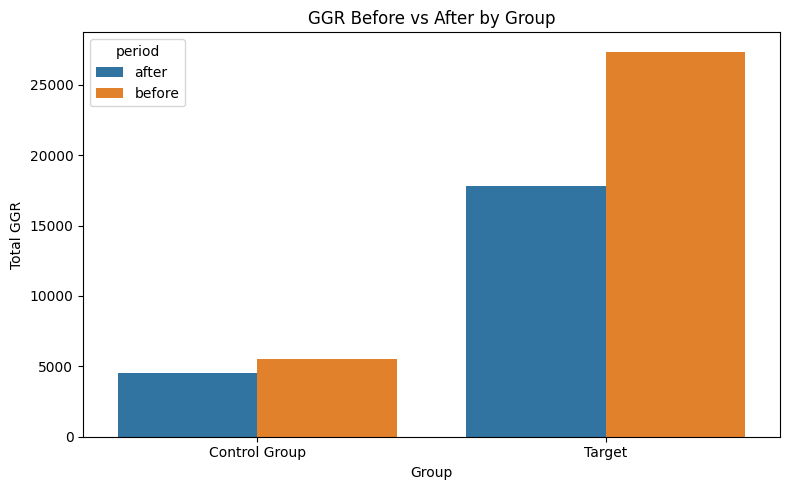

In [107]:
overall_ggr = df.groupby(['Target/CG', 'period'])['ggr'].sum().reset_index()

overall_ggr = overall_ggr[overall_ggr['period'].isin(['before', 'after'])]

plt.figure(figsize=(8,5))
sns.barplot(data=overall_ggr, x='Target/CG', y='ggr', hue='period')
plt.title('GGR Before vs After by Group')
plt.ylabel('Total GGR')
plt.xlabel('Group')
plt.tight_layout()
plt.show()

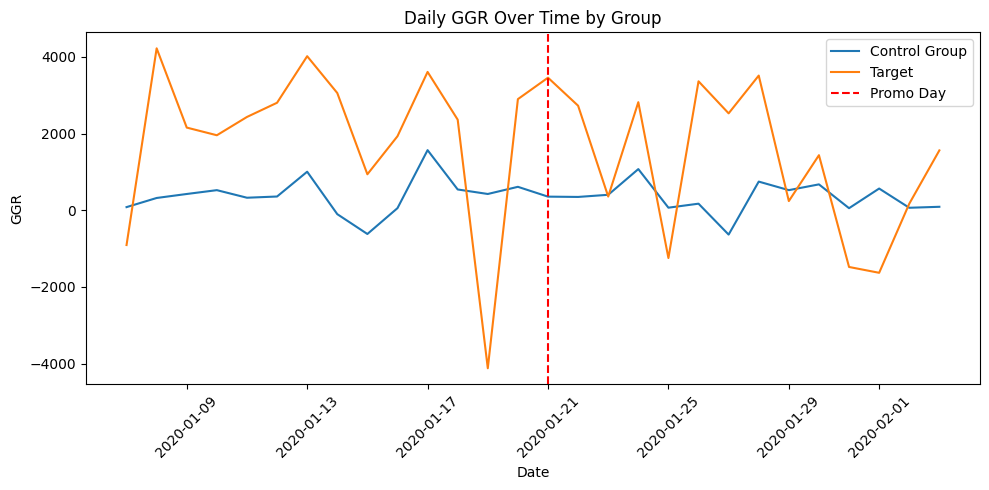

In [108]:
daily_ggr = df.groupby(['date', 'Target/CG'])['ggr'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_ggr, x='date', y='ggr', hue='Target/CG')
plt.axvline(pd.to_datetime('2020-01-21'), color='red', linestyle='--', label='Promo Day')
plt.title('Daily GGR Over Time by Group')
plt.ylabel('GGR')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

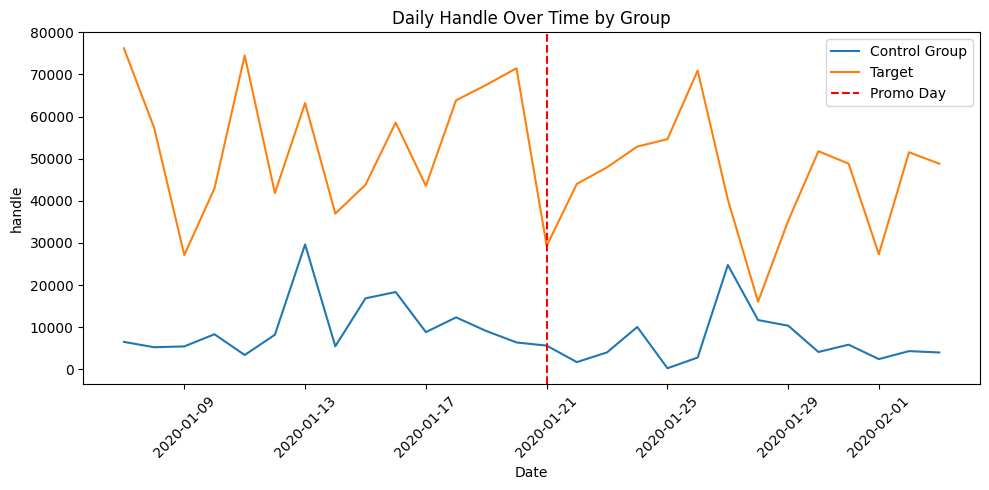

In [109]:
daily_handle = df.groupby(['date', 'Target/CG'])['handle'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_handle, x='date', y='handle', hue='Target/CG')
plt.axvline(pd.to_datetime('2020-01-21'), color='red', linestyle='--', label='Promo Day')
plt.title('Daily Handle Over Time by Group')
plt.ylabel('handle')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [110]:
segment_df = pd.DataFrame(segment_results)

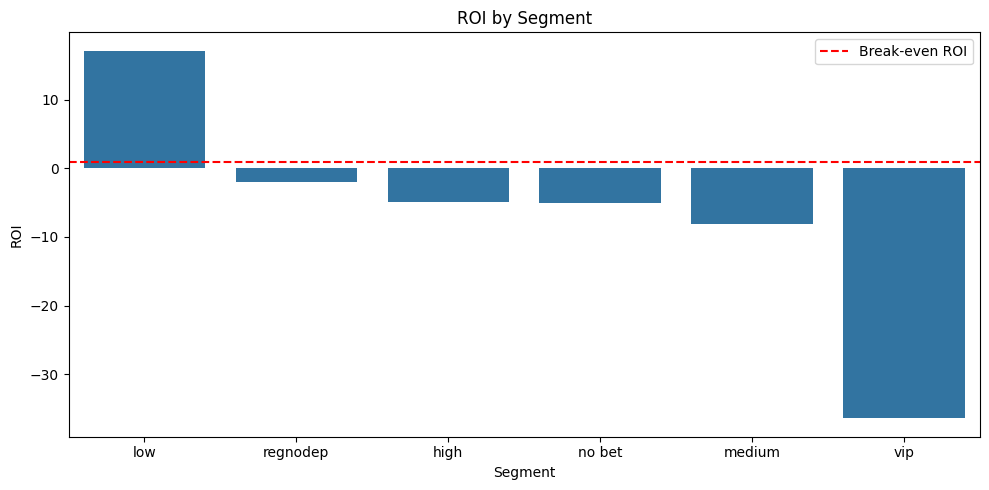

In [112]:
plt.figure(figsize=(10,5))
sns.barplot(data=segment_df.sort_values(by='roi', ascending=False), x='segment', y='roi')
plt.title('ROI by Segment')
plt.ylabel('ROI')
plt.xlabel('Segment')
plt.axhline(1, color='red', linestyle='--', label='Break-even ROI')
plt.legend()
plt.tight_layout()
plt.show()

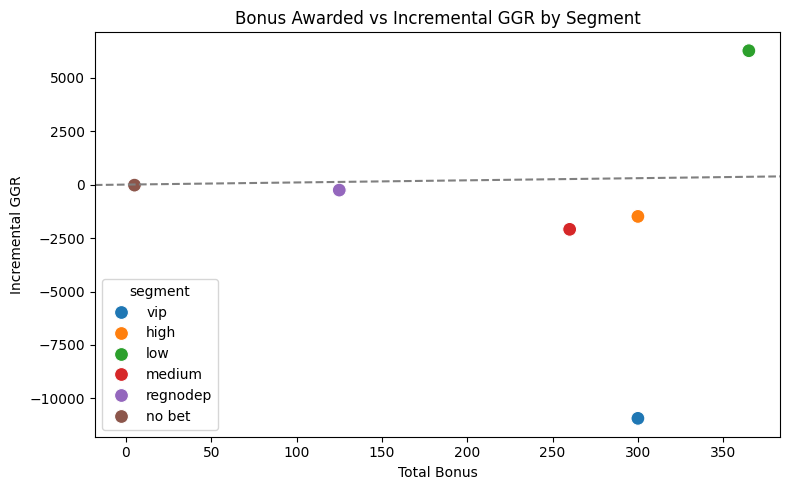

In [113]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=segment_df, x='bonus', y='incremental_ggr', hue='segment', s=100)
plt.title('Bonus Awarded vs Incremental GGR by Segment')
plt.xlabel('Total Bonus')
plt.ylabel('Incremental GGR')
plt.axline((0,0), slope=1, color='gray', linestyle='--')  # 1:1 line
plt.tight_layout()
plt.show()

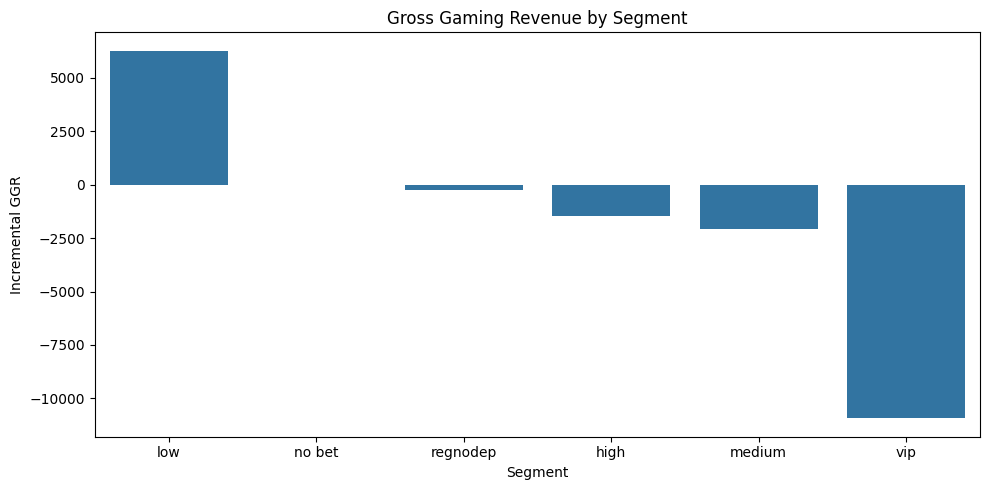

In [116]:
plt.figure(figsize=(10,5))
sns.barplot(data=segment_df.sort_values(by='incremental_ggr', ascending=False), x='segment', y='incremental_ggr')
plt.title('Gross Gaming Revenue by Segment')
plt.ylabel('Incremental GGR')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()


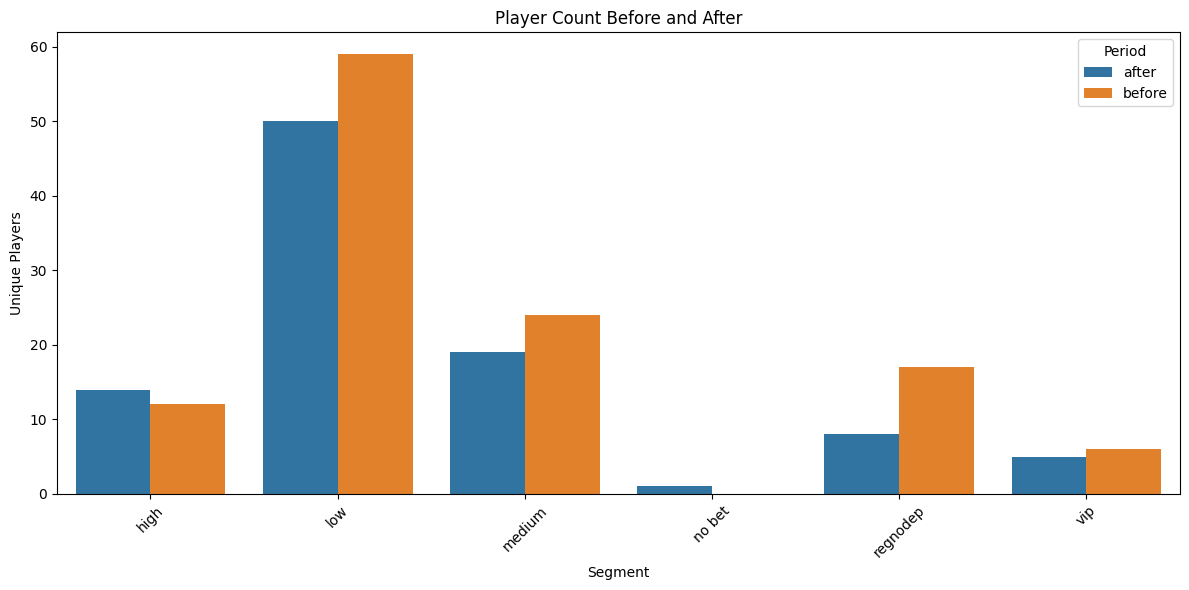

In [117]:
target_df = df[df['Target/CG'] == 'Target']

player_counts_segment_period = target_df.groupby(
    ['last_12months_segment', 'period']
)['playerid'].nunique().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=player_counts_segment_period,
    x='last_12months_segment',
    y='playerid',
    hue='period'
)
plt.title('Player Count Before and After')
plt.ylabel('Unique Players')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.tight_layout()
plt.show()

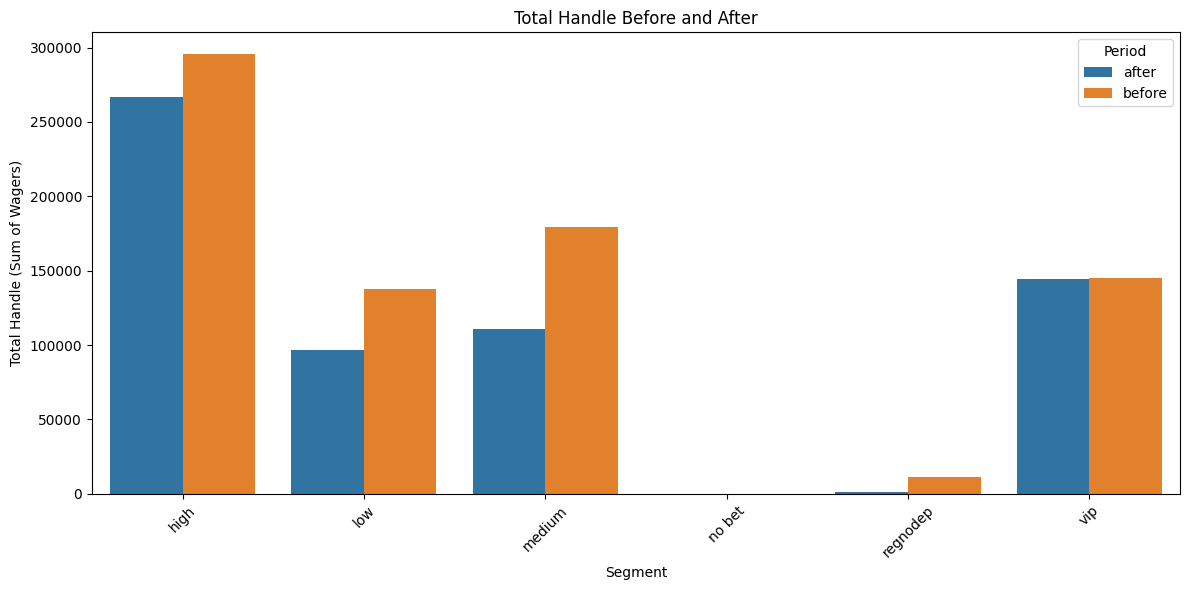

In [118]:
handle_totals = target_df.groupby(['last_12months_segment', 'period'])['handle'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(
    data=handle_totals,
    x='last_12months_segment',
    y='handle',
    hue='period'
)
plt.title('Total Handle Before and After')
plt.ylabel('Total Handle (Sum of Wagers)')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.legend(title='Period')
plt.tight_layout()
plt.show()